In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Felipe Uribe (LUT University)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Parameter estimation in an ODE
### Felipe Uribe (felipe.uribe@lut.fi)

In this notebook, we use CUQIpy to find the stiffness parameters of an undamped equation of motion (ODE). For this we have to define a new forward model, likelihood function, and sampler.

Before getting started we have to import the Python packages we need. Here we also import CUQIpy (cuqi).

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cuqi
from cuqi.distribution import Posterior, Lognormal
from cuqi.likelihood import UserDefinedLikelihood
from cuqi.sampler import Sampler

In [3]:
# set seed
np.random.seed(0)

In [4]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.7.0


## 0. Bayesian inverse problem
Consider the problem of estimating a $\boldsymbol{\theta}\in\mathbb{R}^d$ in the following equation
$$
\boldsymbol{y}=\mathcal{A}(\boldsymbol{\theta}) + \boldsymbol{e},
$$

where $\mathcal{A}: \mathbb{R}^d \to \mathbb{R}^m$ is a nonlinear forward model and $\boldsymbol{y}$ and $\boldsymbol{\theta}$ are random variables representing the observed data and parameter of interest, respectively. Here $\mathbf{e}$ is a random variable representing additive noise in the data.

## 1. Defining the forward model
The foward model involves the solution of the equation of motion for undamped free vibration, which is the ODE:
$$\boldsymbol{y}=\mathcal{A}(\boldsymbol{\theta}) \longrightarrow \boldsymbol{M}\ddot{\boldsymbol{u}}(t) + \boldsymbol{K}(\boldsymbol{\theta}){\boldsymbol{u}(t)} = \boldsymbol{0}\qquad \text{(Option 1)},$$
where $\boldsymbol{M}$ is a deterministic diagonal mass matrix, and $\boldsymbol{K}(\boldsymbol{\theta})$ is a stiffness matrix depending on the uncertain parameters $\boldsymbol{\theta}$. These are defined as:
$$\boldsymbol{M} = \begin{bmatrix} m_1 & 0\\ 0 & m_2\end{bmatrix}\qquad \boldsymbol{K}(\boldsymbol{\theta}) = \begin{bmatrix} k_n\theta_1+k_n\theta_2 & -k_n\theta_2\\ -k_n\theta_2 & k_n\theta_2\end{bmatrix},$$
with masses $m_1=16\,500$ kg, $m_2=16\,100$ kg, and nominal stifness $k_n=29.6\times 10^6$ N/m.

This equation can be solved by assuming a harmonic solution of the form $\boldsymbol{u}=\boldsymbol{\Phi}_j\sin(\omega_j t)$, where $\omega_j$ are the circular natural eigenfrequencies and $\boldsymbol{\Phi}_j$ are the eigenvectors or modal shapes. By performing differentiation of the harmonic solution and substituting into the equation of motion, we obtain an eigenvalue problem. Therefore, the forward model does not require the solution of the original ODE, instead we can solve:
$$\boldsymbol{y}=\mathcal{A}(\boldsymbol{\theta}) \longrightarrow \boldsymbol{K}(\boldsymbol{\theta}) \boldsymbol{\Phi}_j = \omega^2_j \boldsymbol{M} \boldsymbol{\Phi}_j\qquad \text{(Option 2)},$$
from which we obtain $\omega^2_j$ and $\boldsymbol{\Phi}_j$; with the output model eigenfrequencies given by $y_j=\omega_j/2\pi$.

We start by defining the deterministic information of our model:

In [5]:
# set deterministic information of the problem
kn = 29.7e6     # nominal values for the interstory stiffnesses [N/m]
m1 = 16.5e3     # mass 1st story [kg]
m2 = 16.1e3     # mass 2nd story [kg]
M = np.array([[m1, 0],[0, m2]])   # diagonal mass matrix
d = 2  # number of uncertain parameters

With that information we decide to employ the option 2 as forward model. Therefore, we now implement a function solving the underlying eigenvalue problem:

In [6]:
#This can be any function representing the forward computation.
class eigenproblem:
    def __init__(self):
        self.Phi = None

    def forward(self, theta):    
        # Stiffness matrices
        k1, k2 = kn*theta[0], kn*theta[1]
        K = np.array([[k1+k2, -k2],[-k2, k2]])

        # Free response - Modal analysis
        w2, Phi = sp.linalg.eig(K, M)       # gen eigenvalue problem
        w = np.sqrt(np.real(w2))            # frequencies
        f = w/(2*np.pi)                     # natural frequencies [Hz]
        idx = np.argsort(f)                 # ordering (ascendent)
        
        # natural frequencies and vibration modes
        f, self.Phi = f[idx], Phi[:, idx]
        return f

In CUQIpy we can wrap our user-defined function to convert it into a CUQIpy model type:

In [7]:
my_model = eigenproblem()
model_func = cuqi.model.Model(my_model.forward, range_geometry=2, domain_geometry=d)
print(model_func)

CUQI Model: _DefaultGeometry1D(2,) -> _DefaultGeometry1D(2,).
    Forward parameters: ['theta'].


## 2. Prior model
Motivated by the positive nature of the stiffness parameters, the prior distribution of $\boldsymbol{\theta}$ is assumed to be the product of two log-normal PDFs: 
$$p(\boldsymbol{\theta}) = \mathcal{L}\mathcal{N}(\theta_1; \mu_1,\sigma_1)\,\mathcal{L}\mathcal{N}(\theta_2;\mu_2,\sigma_2),$$
In CUQIpy we define this prior as:

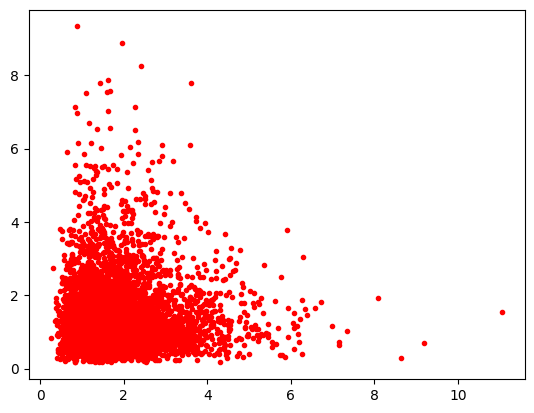

In [8]:
# prior mean
# underlying Gaussian params
mu_pr, sigma_pr = np.array([0.51024, 0.16958]), np.array([0.49787, 0.62667]) 
theta = Lognormal(mean=mu_pr, cov=sigma_pr**2)
theta_s = theta.sample(5000)
plt.figure()
plt.plot(theta_s.samples[0,:], theta_s.samples[1, :], 'r.')
plt.show()


## 3. Likelihood function
We use modal data $\widetilde{\boldsymbol{y}}=[3.13, 9.83]$ corresponding to measured eigenfrequencies in Hz.

The likelihood function is
$$p(\boldsymbol{y}\,|\, \boldsymbol{\theta}) = \exp\left(-\frac{1}{2\widetilde{\sigma}^2}J(\boldsymbol{\theta};\boldsymbol{y})\right),$$
where $\widetilde{\sigma}^2=1/(2^8)$ is the noise variance, and $J(\boldsymbol{\theta};\boldsymbol{y})$ is the modal measure-of-fit function which depends on the data and forward model:
$$J(\boldsymbol{\theta};\boldsymbol{y})=\sum_{j=1}^{2} \widetilde{\mu}_j^2\left(\frac{y_j^2(\boldsymbol{\theta})}{\widetilde{\boldsymbol{y}}_j^2}-1\right)^2,$$
where $\widetilde{\boldsymbol{\mu}}=[1,1]$ is the mean of prediction error, and we use the notation $y_j^2(\boldsymbol{\theta})$ for the $j$-th eigenfrequency obtained by the forward model solution.

In CUQIpy we define this particular likelihood as:

In [9]:
# measured data
y_data = np.array([3.13, 9.83])  # eigenfrequencies in Hz
m = len(y_data)

# noise parameters
mu_obs = np.array([1, 1])  # mean of prediction error
s2_y = 1/(2**8)            # noise var
lambda_y = 1/s2_y          # noise prec

# measure-of-fit function
J = lambda theta: sum( (mu_obs**2) * (((model_func(theta)**2)/(y_data**2))-1)**2 )

# create an user-defined likelihood
logp_like = lambda theta: -0.5*lambda_y*J(theta)
y = UserDefinedLikelihood(dim=m, logpdf_func=logp_like, geometry=model_func.range_geometry)

## 4. Posterior distribution
We build the posterior distribution using the prior and likelihood:

In [10]:
posterior = Posterior(prior=theta, likelihood=y)
print(posterior)

Posterior(
    Equation:
	 p(theta|y) ∝ L(theta|y)p(theta)
    Densities:
	y ~ CUQI UserDefinedLikelihood function. Parameters ['theta'].
 	theta ~ CUQI Lognormal.
 )


## 5. Sampling the posterior

Now that we have defined the posterior distribution for our parameter of interest $\boldsymbol{\theta}$ given $\widetilde{\boldsymbol{y}}$, we can characterize the parameter and its uncertainty by samples from the posterior distribution. However, in general the posterior is not a simple distribution that we can easily sample from. Instead, we need to rely on Markov Chain Monte Carlo (MCMC) methods to sample from the posterior.

As we need the proposed states to be positive, we define the proposal distribution of the Metropolis-Hastings as the prior. This type of MCMC is known as the independence sampler, as the proposed states are independent of the previous ones. One advantage is that we do not need to adapt any step-size parameters.


In [11]:
class IS(Sampler):
    def __init__(self, target, x0=None, dim=None, **kwargs):
        """ Independence sampler (IS) sampler. The proposal is the prior"""
        super().__init__(target, x0=x0, dim=dim, **kwargs)
        
    @property
    def prior(self):
        if isinstance(self.target, cuqi.distribution.Posterior):
            return self.target.prior
        elif isinstance(self.target,tuple) and len(self.target)==2:
            return self.target[1]

    @property
    def likelihood(self):
        if isinstance(self.target, cuqi.distribution.Posterior):
            return self.target.likelihood
        elif isinstance(self.target,tuple) and len(self.target)==2:
            return self.target[0]

    @Sampler.target.setter 
    def target(self, value):
        if isinstance(value, cuqi.distribution.Posterior):
            self._target = value
            self._prior_rvs = lambda n: self.prior.sample(n)
            self._loglikelihood = lambda x : self.likelihood.logd(x)
        elif isinstance(value,tuple) and len(value)==2 and \
             (isinstance(value[0], cuqi.likelihood.Likelihood) or \
              isinstance(value[0], cuqi.likelihood.UserDefinedLikelihood))  and \
             isinstance(value[1], cuqi.distribution.Distribution):
            self._target = value
            self._prior_rvs = lambda n: self.prior.sample(n)
            self._loglikelihood = lambda x : self.likelihood.logd(x)
        else:
            raise ValueError(f"To initialize an object of type {self.__class__}, \
                             'target' need to be of type 'cuqi.distribution.Posterior'.")

    @property
    def dim(self):
        if hasattr(self,'target') and hasattr(self.target,'dim'):
            self._dim = self.target.dim
        elif hasattr(self,'target') and isinstance(self.target,tuple) and len(self.target)==2:
            self._dim = self.target[0].dim
        return self._dim
        
    def _sample_adapt(self, N, Nb):
        samples, target_eval, accave = self._sample(N, Nb)
        return samples, target_eval, accave
    
    def _sample(self, N, Nb):
        Ns = N+Nb   # number of simulations

        # allocation
        samples = np.empty((self.dim, Ns))
        target_eval = np.empty(Ns)
        acc = np.zeros(Ns, dtype=int)

        # initial state    
        samples[:, 0] = self.x0
        target_eval[0] = self._loglikelihood(self.x0)
        acc[0] = 1

        # run MCMC
        for s in range(Ns-1):
            # run component by component
            samples[:, s+1], target_eval[s+1], acc[s+1] = \
                self.single_update(samples[:, s], target_eval[s])
            #s+2 is the sample number, s+1 is index assuming x0 is the first sample
            self._print_progress(s+2,Ns)
            self._call_callback(samples[:, s+1], s+1)

        # remove burn-in
        samples = samples[:, Nb:]
        target_eval = target_eval[Nb:]
        accave = acc[Nb:].mean()   
        print('\nAverage acceptance rate:', accave, '\n')

        return samples, target_eval, accave

    def single_update(self, x_t, target_eval_t):
        # propose state
        x_star = self._prior_rvs(1)   # sample from the proposal

        # evaluate target
        target_eval_star = self._loglikelihood(x_star)

        # ratio and acceptance probability
        ratio = target_eval_star - target_eval_t  # proposal is symmetric
        alpha = min(0, ratio)

        # accept/reject
        u_theta = np.log(np.random.rand())
        if (u_theta <= alpha):
            x_next = x_star
            target_eval_next = target_eval_star
            acc = 1
        else:
            x_next = x_t
            target_eval_next = target_eval_t
            acc = 0
        
        return x_next, target_eval_next, acc

Now we are ready to set the sampler and run it:

In [12]:
# set the sampler
sampler = IS(target=posterior, x0=np.array([1, 1]))

# run the sampler
Nc = int(1e5)
Nb = int(1e4)
Nt = 20
K = int(Nt*Nc)
samples = sampler.sample(K, Nb=Nb)

Sample 2010000 / 2010000

Average acceptance rate: 0.003204 



We do some postprocessing by first thinning the posterior samples:

In [13]:
# assign the posterior samples to each variable and apply thinning Nt
theta_1 = samples.samples[0, 0:-1:Nt]
theta_2 = samples.samples[1, 0:-1:Nt]
mu_pos_1 = np.mean(theta_1)
mu_pos_2 = np.mean(theta_2)
print('The posterior mean is:', mu_pos_1, mu_pos_2)

The posterior mean is: 1.139182202178348 0.5823733200448783


Then we plot the chains against the (stationary) means:

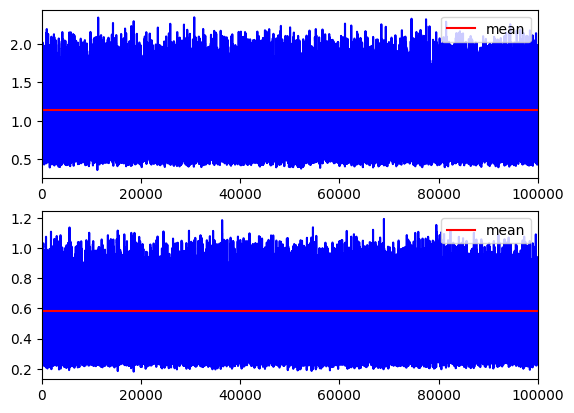

In [14]:
# plot the chains
fig, ax = plt.subplots(2)
ax[0].plot(theta_1, 'b-')
ax[0].axhline(y = mu_pos_1, color = 'r', linestyle = '-', label="mean") 
ax[0].set_xlim(0, Nc)
ax[0].legend(loc='upper right')
ax[1].plot(theta_2, 'b-')
ax[1].axhline(y = mu_pos_2, color = 'r', linestyle = '-', label="mean") 
ax[1].set_xlim(0, Nc)
ax[1].legend(loc='upper right')

Next we plot the ergodic means.

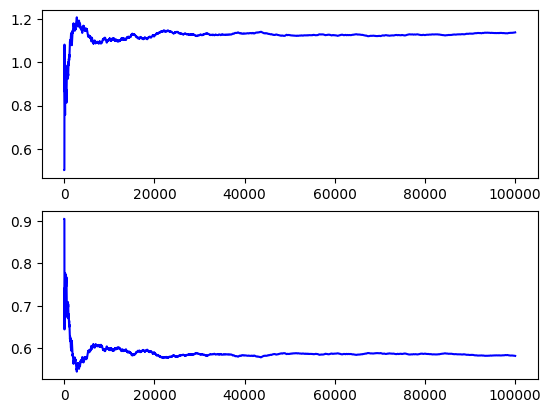

In [15]:
# plot ergodic mean
mu_erg_1 = np.array([np.mean(theta_1[:i+1]) for i in range(Nc)])
mu_erg_2 = np.array([np.mean(theta_2[:i+1]) for i in range(Nc)])
fig, ax = plt.subplots(2)
ax[0].plot(mu_erg_1, 'b-')
ax[1].plot(mu_erg_2, 'b-')

The above plots show that both the stationary and ergodic means have reached convergence. However, a zoomed-in view reveals that the samples seem to be flipping between two extreme values, which is a bit suspicious!

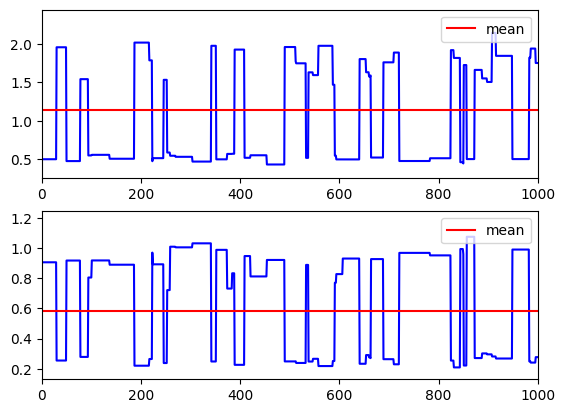

In [16]:
fig, ax = plt.subplots(2)
ax[0].plot(theta_1, 'b-')
ax[0].axhline(y = mu_pos_1, color = 'r', linestyle = '-', label="mean")
ax[0].legend(loc='upper right')
ax[0].set_xlim(0, 1000)
ax[1].plot(theta_2, 'b-')
ax[1].axhline(y = mu_pos_2, color = 'r', linestyle = '-', label="mean")
ax[1].set_xlim(0, 1000)
ax[1].legend(loc='upper right')

What's more, the samples also show very strong correlation!

array([<Axes: title={'center': 'theta0'}>,
       <Axes: title={'center': 'theta1'}>], dtype=object)

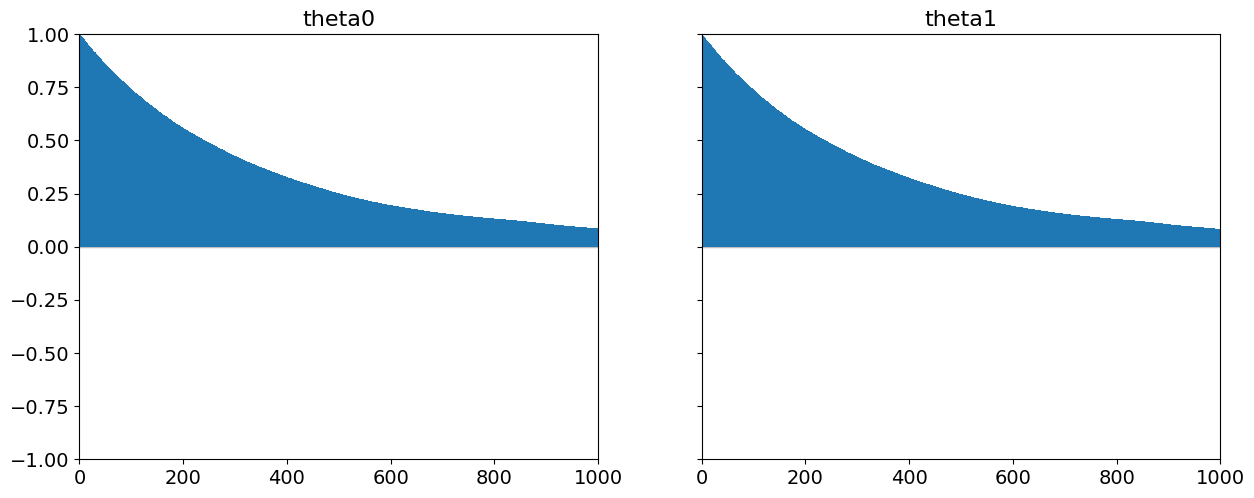

In [17]:
# plot autocorrelation
samples.plot_autocorrelation(max_lag=1000)

Everything becomes clear when we take a look at a distribution plot of the samples: as the following plot shows, the posterior distribution exhibits a bimodal behavior, which can be easily missed if one only looks at the mean plot. Again here the red lines indicate the locations of the means.

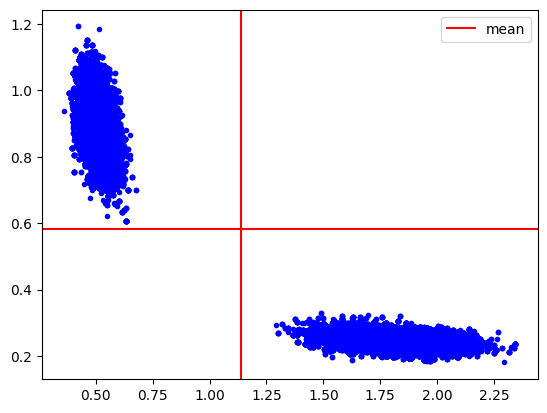

In [18]:
# plot the joint
plt.figure()
plt.plot(theta_1, theta_2, 'b.')
plt.axhline(y = mu_pos_2, color = 'r', linestyle = '-', label="mean")
plt.axvline(x = mu_pos_1, color = 'r', linestyle = '-')
plt.legend()

So far, we have explored performing inverse inference with a custom forward model and a custom sampler in CUQIpy. This notebook also serves as an example to show limitations of relying solely on the posterior mean as an estimator. Specifically, when dealing with correlated multimodal densities, the posterior mean may prove to be a suboptimal estimator. Please also note that, in this example, there are no reference values for theta, as the data comes as given.